In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.linear_model import LinearRegression

In [16]:
df = pd.read_csv('CGMData/cgm-19032024_123732.csv')
display(df)

,DeviceType,SerialNumber,Description,EventDateTime,Readings (CGM / BGM)
0,t:slim X2 Insulin Pump,1026835,EGV,3/5/2024 0:03,153
1,t:slim X2 Insulin Pump,1026835,EGV,3/5/2024 0:08,161
2,t:slim X2 Insulin Pump,1026835,EGV,3/5/2024 0:13,171
3,t:slim X2 Insulin Pump,1026835,EGV,3/5/2024 0:18,185
4,t:slim X2 Insulin Pump,1026835,EGV,3/5/2024 0:23,198
...,...,...,...,...,...
3972,t:slim X2 Insulin Pump,1026835,EGV,3/18/2024 23:36,400
3973,t:slim X2 Insulin Pump,1026835,EGV,3/18/2024 23:41,400
3974,t:slim X2 Insulin Pump,1026835,EGV,3/18/2024 23:46,400
3975,t:slim X2 Insulin Pump,1026835,EGV,3/18/2024 23:51,400


In [17]:
df = df.drop(columns=['SerialNumber', 'Description', 'DeviceType'])

# Convert the 'DateTime' column to datetime format
df['DateTime'] = pd.to_datetime(df['EventDateTime'], format='%m/%d/%Y %H:%M')

# Extract hour and minute features
df['Hour'] = df['DateTime'].dt.hour
df['Minute'] = df['DateTime'].dt.minute

df = df.drop(columns=['EventDateTime'])

display(df)

,Readings (CGM / BGM),DateTime,Hour,Minute
0,153,2024-03-05 00:03:00,0,3
1,161,2024-03-05 00:08:00,0,8
2,171,2024-03-05 00:13:00,0,13
3,185,2024-03-05 00:18:00,0,18
4,198,2024-03-05 00:23:00,0,23
...,...,...,...,...
3972,400,2024-03-18 23:36:00,23,36
3973,400,2024-03-18 23:41:00,23,41
3974,400,2024-03-18 23:46:00,23,46
3975,400,2024-03-18 23:51:00,23,51


In [14]:
df = df.dropna()

last_3_days_data = df[df['DateTime'] >= df['DateTime'].max() - timedelta(days=3)]

# Split the data into training and testing sets
X = last_3_days_data[['Hour', 'Minute']]
y = last_3_days_data['Readings (CGM / BGM)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train the RandomForestRegression model
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

# Make predictions for 30 minutes into the future
predictions = rf.predict(X_test)

# Calculate and print the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Example prediction for the next 30 minutes
next_hour = df['Hour'].iloc[-1]  # Assuming the last entry in the DataFrame is the latest hour
next_minute = df['Minute'].iloc[-1] + 30  # Adding 30 minutes to the latest minute
if next_minute >= 60:
    next_hour += 1
    next_minute -= 60
prediction_input = np.array([[next_hour, next_minute]])
next_prediction = rf.predict(prediction_input)
print(f'Predicted glucose reading for {next_hour:02d}:{next_minute:02d}: {next_prediction[0]}')

Mean Squared Error: 5599.353171378048
Predicted glucose reading for 24:26: 271.7721666666667


c:\Users\zar10\miniconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


ValueError: x and y must have same first dimension, but have shapes (865,) and (173,)

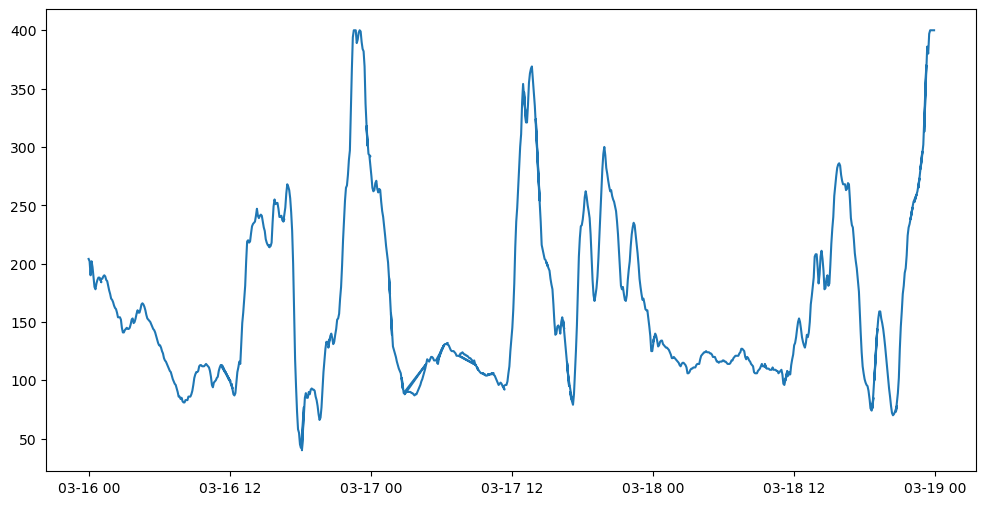

In [7]:
# Filter the DataFrame to include only the data for the last 3 days
last_3_days_data = df[df['DateTime'] >= df['DateTime'].max() - timedelta(days=3)]

# Make predictions for the last 3 days
#predictions = rf.predict(last_3_days_data[['Hour', 'Minute']])

# Plot the actual and predicted glucose readings for the last 3 days
plt.figure(figsize=(12, 6))
plt.plot(last_3_days_data['DateTime'], last_3_days_data['Readings (CGM / BGM)'], label='Actual Readings')
plt.plot(last_3_days_data['DateTime'], predictions, label='Predicted Readings', linestyle='--')
plt.xlabel('Date and Time')
plt.ylabel('Glucose Readings')
plt.title('Actual vs. Predicted Glucose Readings for Last 3 Days')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()